# Model evaluation against the test set:
#### This notebook tests the model against a withheld test set which is taken from seperate locations to the training and validation set.



In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# imports
from pathlib import Path
import sys
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
model_save_path = BASE_PATH / 'models'
import pandas as pd
import opensoundscape as opso
from opensoundscape import audio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ipywidgets import interact
import glob
from src.utils import  show_samples_in_df, get_binary_targets_scores, suppress_warnings_if_main_branch, plot_metrics_across_thresholds, hawkears_files_to_df, plot_confusion_matrix, save_dataframe_clips_to_disk

In [3]:
suppress_warnings_if_main_branch()

%load_ext autoreload
%autoreload 2

# Load the data

In [4]:
# load the validation data
data_path = Path.cwd().parent.parent / "data"
test_df = pd.read_pickle(data_path / "interim" / "test_set" / "balanced_test_set_verified.pkl")

In [5]:
test_df.source.value_counts()

source
withheld-test-set        500
SingleSpecies_all.csv    300
other-habitats-absent    300
Name: count, dtype: int64

for some datasets there are examples which need re-labelling. The function clean_confidence_cats will help with this:

In [6]:
def clean_confidence_cats(df, drop_unchecked=False):
    # Re-label the mis-labelled clips
    df.loc[df["confidence_cat"] == 5, "target_present"] = 1.0
    df.loc[df["confidence_cat"] == 6, "target_present"] = 0.0

    # drop the clips with confidence 1 or 2 since these were hard to label.
    df = df[df["confidence_cat"] != 1]
    df = df[df["confidence_cat"] != 2]
    if drop_unchecked:
        # Drop the unverified clips
        df = df[df["confidence_cat"] != 0]
    return df

In [7]:
test_df = clean_confidence_cats(test_df)
test_ds = test_df[["target_present"]]

In [10]:
# This dataset remains unchanged after cleaning
test_df.target_present.value_counts()

target_present
1.0    800
0.0    800
Name: count, dtype: int64

# Load a saved model

In [11]:
model = opso.load_model(model_save_path / "OSFL.model")

# Make predictions with the model

In [12]:
predictions = model.predict(test_ds, batch_size=64, num_workers=0, activation_layer='sigmoid')

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
test_df['predicted'] = predictions.target_present

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


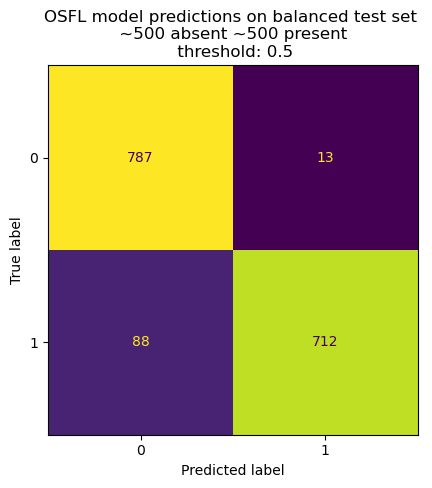

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.interactive_confusion_matrix(threshold=0.5)>

In [14]:
title = "OSFL model predictions on balanced test set \n ~500 absent ~500 present"
cm = plot_confusion_matrix(test_df,predictions,threshold=0.5, title=title)
def interactive_confusion_matrix(threshold=0.5):
    cm = plot_confusion_matrix(test_df,predictions,threshold=threshold, title=title)
interact(interactive_confusion_matrix, threshold=(0,1,0.01))

# Plot metrics across thresholds

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


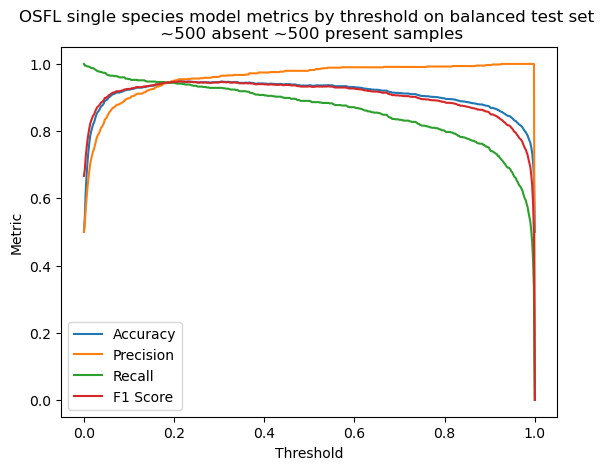

In [15]:
title = "OSFL single species model metrics by threshold on balanced test set \n ~500 absent ~500 present samples"
_, _ = plot_metrics_across_thresholds(test_df, 'predicted', 'target_present', title = title)

# Collect the errors

In [16]:
false_positives = test_df.loc[test_df['predicted'] > 0.2].loc[test_df['target_present'] == 0.0]
false_negatives = test_df.loc[test_df['predicted'] < 0.2].loc[test_df['target_present'] == 1.0]
len(false_positives), len(false_negatives)

(39, 45)

# Show the false negatives
This is a sample of the 21 examples which our model missed when the threshold was set to 0.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

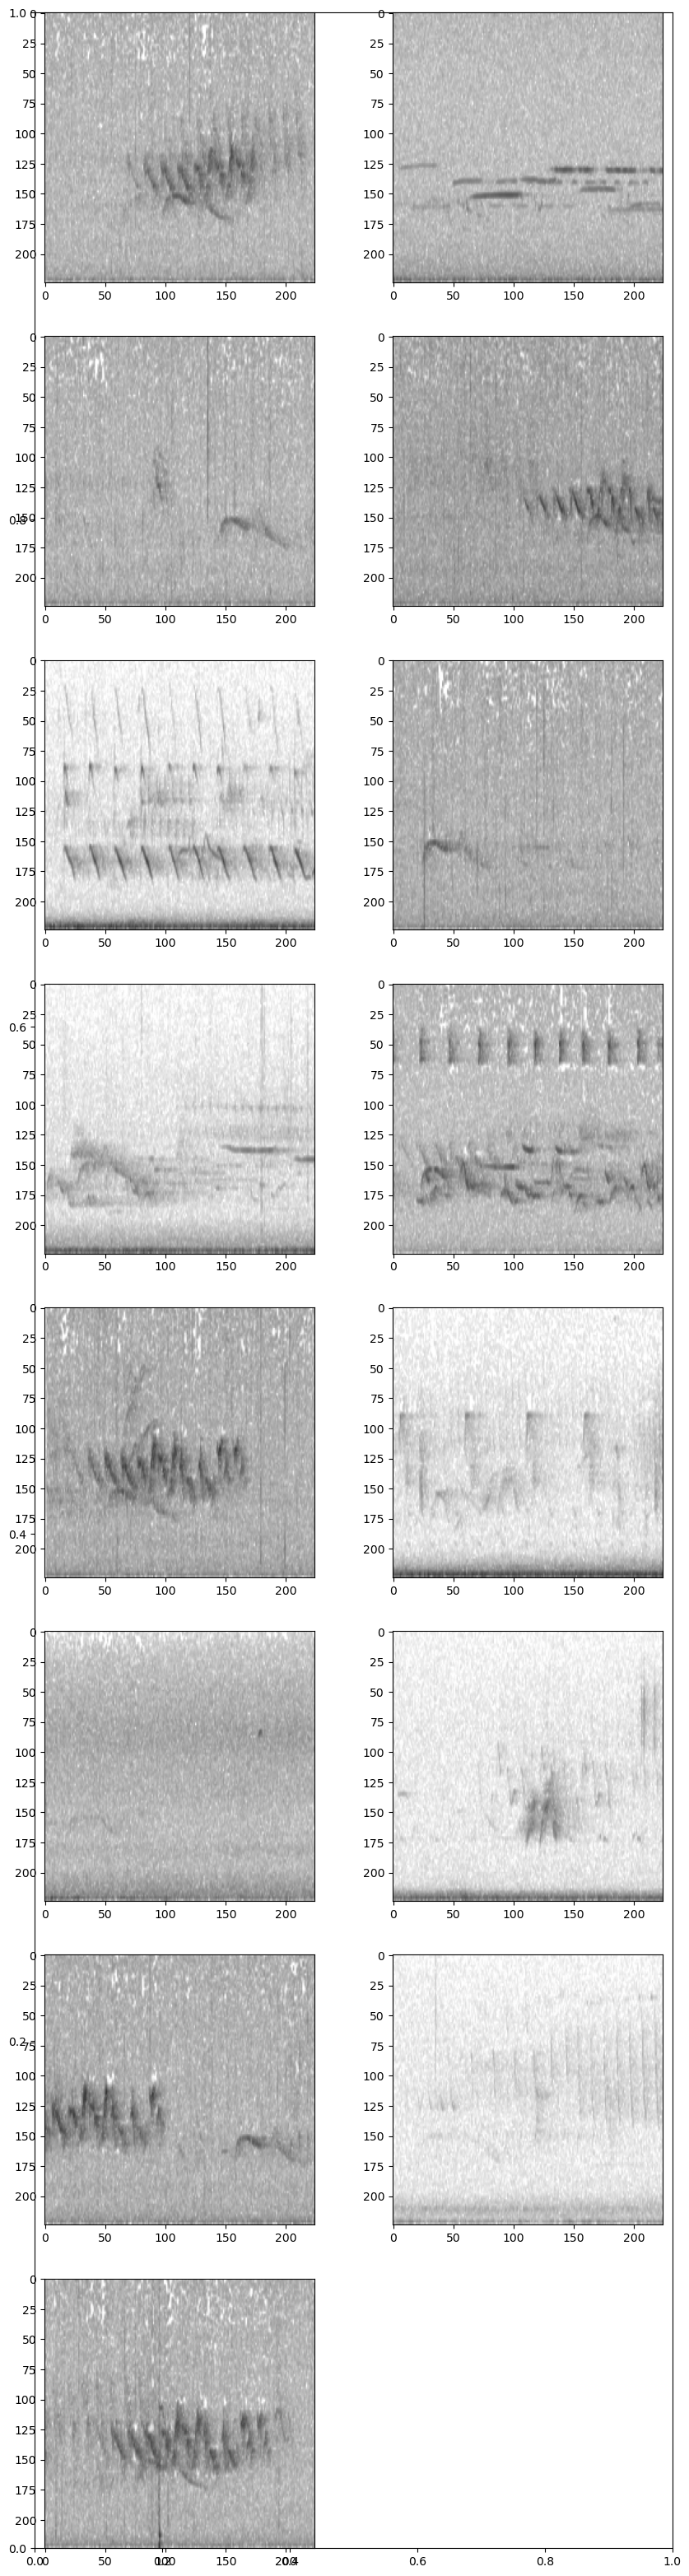

In [17]:
show_samples_in_df(false_negatives.sample(15), model)

# Show the false positives
This is a sample from the 36 negative examples our model identified as positives when the threshold was set to 0.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

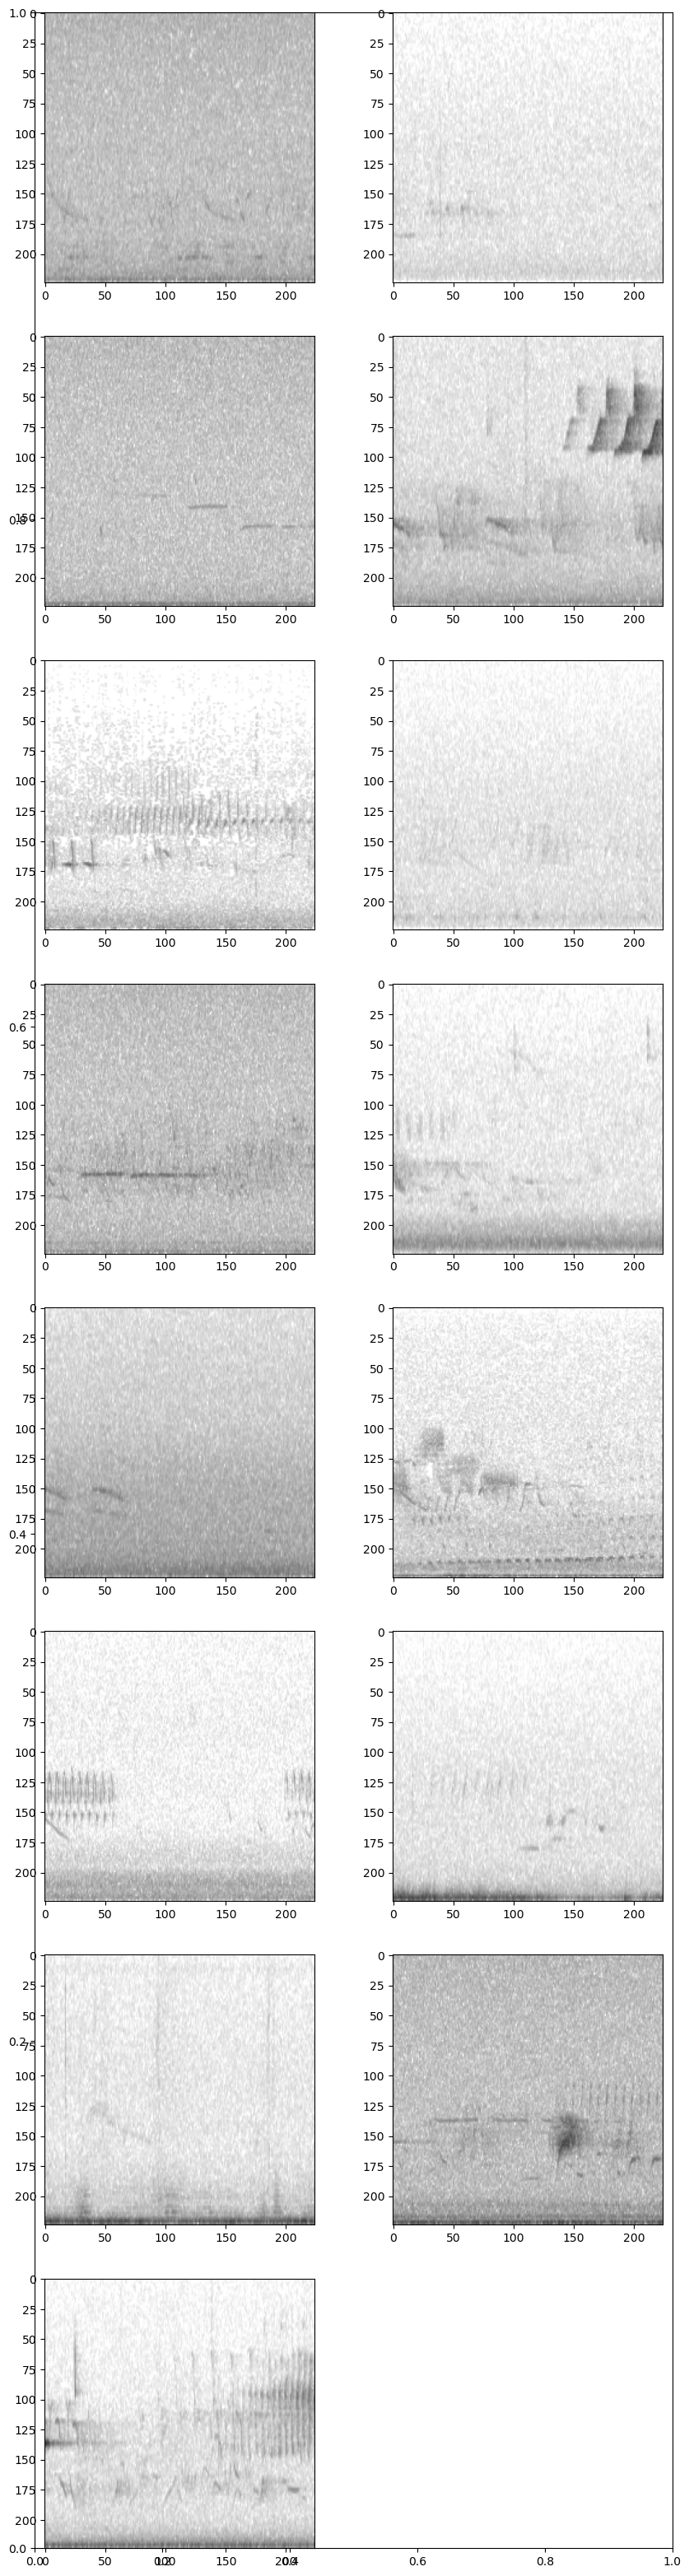

In [18]:
show_samples_in_df(false_positives.sample(15), model)

# Other habitat audio
We made a dataset of audio from outside the target species habitat. We can use this to get an idea of how many additional false positives are likely to show up if the model is used in new areas.

Make predictions on a set of samples from outside the target habitat

In [21]:
other_habitats_preds = model.predict(test_df.loc[test_df["source"] == 'other-habitats-absent'], batch_size=64, num_workers=4, activation_layer='sigmoid')

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: must be real number, not str

In [ ]:
sum(other_habitats_preds.target_present < 0.8), sum(other_habitats_preds.target_present < 0.5)

(496, 489)

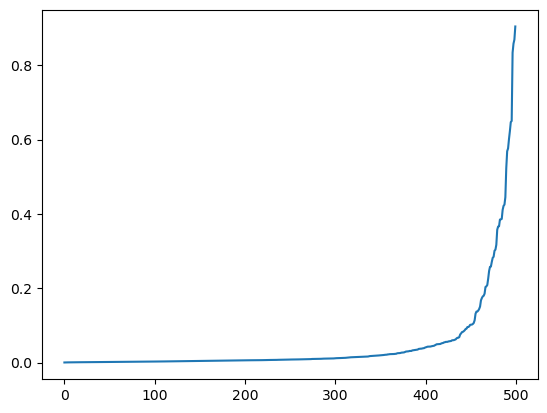

In [ ]:
# Show the distribution of the 300 predictions. 
plt.plot(sorted(other_habitats_preds.target_present.values))

The number of false positives found in the other habitats recordings is promising, especially since half of the values in this data set are intentionally picked from the highest errors returned by a previous model.

# Compare with other existing models
#### To make a direct comparison between models, we need to measure the models predictions on the same test sets. 

To compare the models with others such as Birdnet, HawkEars, Perch etc, we can export the 3 second segments of audio to disk then get the model predictions on these clips. Then we can load these predictions and compare directly with the predictions our model made on those same audio clips. 

# To make hawkears predictions on each clip in the test set:
1. Enumerate the clips in the dataset for easier file naming
2. Make the save paths to save the audio to
3. Save the clips to disk
4. Run hawkears on the clips and output to the folder specified by __predictions path__ 
5. Load the predictions ready for processing the metrics

# Ennumerate each clip in the dataset

In [22]:
# Add an index to the training clips to use as a file ID
test_df["file_ID"] = 0
test_df.loc[:, 'file_ID'] = range(0, len(test_df))
test_df.loc[:, 'file_ID'] = test_df['file_ID'].astype(int)
test_df.head()

recording_url  \
file                                               start_time end_time                                                      
../../data/raw/recordings/OSFL/recording-50028.... 12.0       15.0      https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
                                                   63.0       66.0      https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
../../data/raw/recordings/OSFL/recording-70937.mp3 13.5       16.5      https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
../../data/raw/recordings/OSFL/recording-97916.mp3 67.5       70.5      https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
                                                   69.0       72.0      https://wildtrax-aru.s3.us-west-2.amazonaws.co...   

                                                                       task_method  \
file                                               start_time end_time               
../../data/raw/recordings/OSFL/recording-50028.... 12.0       15.0            1SPM   
                                                   63.0       66.0            1SPM   
../../data/raw/recordings/OSFL/recording-70937.mp3 13.5       16.5            1SPM   
../../data/raw/recordings/OSFL/recording-97916.mp3 67.5       70.5            1SPT   
                                                   69.0       72.0            1SPT   

                                                                                                                  project  \
file                                               start_time end_time                                                      
../../data/raw/recordings/OSFL/recording-50028.... 12.0       15.0                    Boreal Wetland Community Monitoring   
                                                   63.0       66.0                    Boreal Wetland Community Monitoring   
../../data/raw/recordings/OSFL/recording-70937.mp3 13.5       16.5                                              Big Grids   
../../data/raw/recordings/OSFL/recording-97916.mp3 67.5       70.5      YT High Elevation Monitoring Program CWS North...   
                                                   69.0       72.0      YT High Elevation Monitoring Program CWS North...   

                                                                               detection_time  \
file                                               start_time end_time                          
../../data/raw/recordings/OSFL/recording-50028.... 12.0       15.0      [12.2, 63.13, 122.71]   
                                                   63.0       66.0      [12.2, 63.13, 122.71]   
../../data/raw/recordings/OSFL/recording-70937.mp3 13.5       16.5       [14.53, 60.5, 120.5]   
../../data/raw/recordings/OSFL/recording-97916.mp3 67.5       70.5                    [69.06]   
                                                   69.0       72.0                    [69.06]   

                                                                              tag_duration  \
file                                               start_time end_time                       
../../data/raw/recordings/OSFL/recording-50028.... 12.0       15.0      [1.55, 1.39, 1.48]   
                                                   63.0       66.0      [1.55, 1.39, 1.48]   
../../data/raw/recordings/OSFL/recording-70937.mp3 13.5       16.5      [1.13, 1.13, 1.13]   
../../data/raw/recordings/OSFL/recording-97916.mp3 67.5       70.5                  [1.24]   
                                                   69.0       72.0                  [1.24]   

                                                                         latitude  \
file                                               start_time end_time              
../../data/raw/recordings/OSFL/recording-50028.... 12.0       15.0      57.363503   
                                                   63.0       66.0      57.363503   
../../data/raw/recordings/OSFL/recording-70937.mp3 13.5       16.5      56

In [24]:
# Make a path to save the clips to
save_path = data_path / "processed" / "test_set" / "clips"
Path.mkdir(save_path, exist_ok=True, parents=True)

# Save the metadata in the same place or load it if there is already a saved version
if Path.exists(save_path.parent / "test_set.pkl"):
    test_df = pd.read_pickle(save_path.parent / "test_set.pkl")
    print("loading existing metadata")
else: 
    save_dataframe_clips_to_disk(test_df, save_path)
    test_df.to_pickle(save_path.parent / "test_set.pkl")
    print("saving metadata")

Saving clips to disk
saving metadata


In [25]:
save_dataframe_clips_to_disk(test_df, save_path)

Directory is not empty. Set an empty save directory before saving clips.


# Make predictions on these clips using an existing model then parse the results

Comparison could be made with BirdNet, Perch etc, but I've chosen to compare to HawkEars since I believe it to be the best available model for this species in this region. 

Predictions are made locally by cloning the hawkears GitHub repository and running the following lines in the terminal from the root of the hawkears repository:

``` 
python3 analyze.py -i <path to input clips> -o <path to output results>
```

The output path was chosen as the parent folder of the audio clips. 

In [62]:
# Set the location of hawkears prediction files
predictions_path = save_path.parent / "hawkears"
# Load the file paths
hawkears_files = glob.glob(str(predictions_path / '*.txt'))

In [53]:
# Process the hawkears files into a dataframe.
hawkears_df = hawkears_files_to_df(hawkears_files, target_species="OSFL")
hawkears_df.rename(columns={"confidence": "target_present"}, inplace=True)

In [54]:
hawkears_df.head()

file_id start_time end_time species  target_present
0        0       0.00     3.00    OSFL            0.01
1        1       0.00     3.00    OSFL            0.01
2        2       0.00     3.00    OSFL            0.02
3        3       0.00     3.00    OSFL            0.01
4        4       0.00     3.00    OSFL            0.01

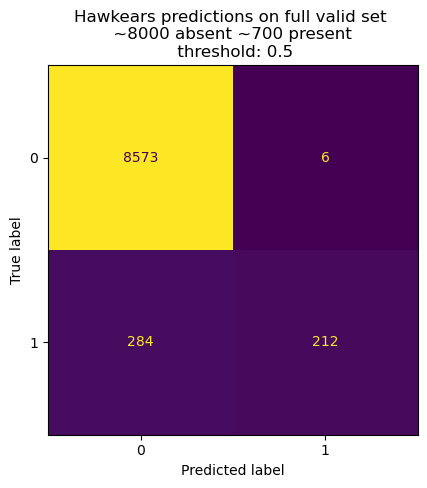

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.interactive_confusion_matrix(threshold=0.5)>

In [55]:
title = "Hawkears predictions on full valid set \n ~8000 absent ~500 present"
cm = plot_confusion_matrix(valid_df,hawkears_df,threshold=0.5, title=title)
def interactive_confusion_matrix(threshold=0.5):
    cm = plot_confusion_matrix(valid_df,hawkears_df,threshold=threshold, title=title)
interact(interactive_confusion_matrix, threshold=(0,1,0.01))

In [25]:
# confirm that the valid df contains the target present label
valid_df[['target_present', "file_ID"]].head()

target_present  \
file                                              start_time end_time                   
../../data/raw/recordings/OSFL/recording-4427.mp3 0.0        3.0                  0.0   
                                                  1.5        4.5                  0.0   
                                                  3.0        6.0                  0.0   
                                                  4.5        7.5                  0.0   
                                                  6.0        9.0                  0.0   

                                                                       file_ID  
file                                              start_time end_time           
../../data/raw/recordings/OSFL/recording-4427.mp3 0.0        3.0             0  
                                                  1.5        4.5             1  
                                                  3.0        6.0             2  
                                                  4.5        7.5             3  
                                                  6.0        9.0             4

In [26]:
# Model predictions also get stored in a column called target_present
hawkears_df[['target_present']].head()

target_present
0            0.01
1            0.01
2            0.02
3            0.01
4            0.01

In [27]:
preds, targets, scores = get_binary_targets_scores(valid_df, hawkears_df, 0.5)
hawkears_scores_and_targets_df = pd.DataFrame({'hawkears_scores': scores, 'targets': targets})
hawkears_scores_and_targets_df.head()

hawkears_scores  targets
0             0.01      0.0
1             0.01      0.0
2             0.02      0.0
3             0.01      0.0
4             0.01      0.0

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-

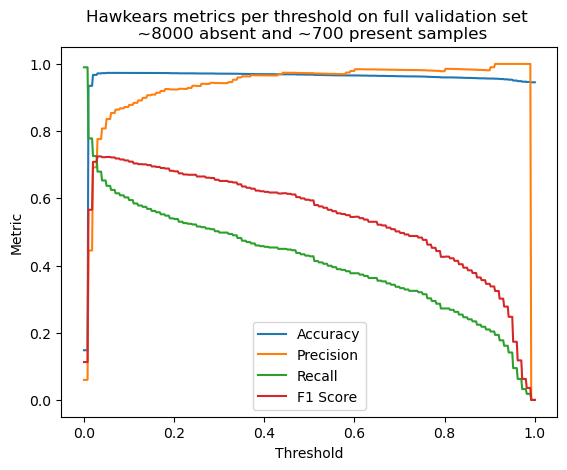

In [28]:
title = "Hawkears metrics per threshold on full validation set \n ~8000 absent and ~500 present samples"
plot_data, legend = plot_metrics_across_thresholds(hawkears_scores_and_targets_df, 'hawkears_scores', 'targets', title=title)

# Repeat this process on the balanced validation set with equal numbers of samples per class

In [29]:
balanced_valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "balanced_valid_set_verified.pkl")
balanced_valid_df = clean_confidence_cats(balanced_valid_df)
balanced_valid_df.confidence_cat.value_counts()

confidence_cat
3    748
4     43
6      1
5      1
Name: count, dtype: int64

# Make predictions with the model

In [30]:
predictions = model.predict(balanced_valid_df[["target_present"]], batch_size=64, num_workers=4, activation_layer='sigmoid')

  0%|          | 0/13 [00:00<?, ?it/s]

In [31]:
balanced_valid_df['predicted'] = predictions.target_present

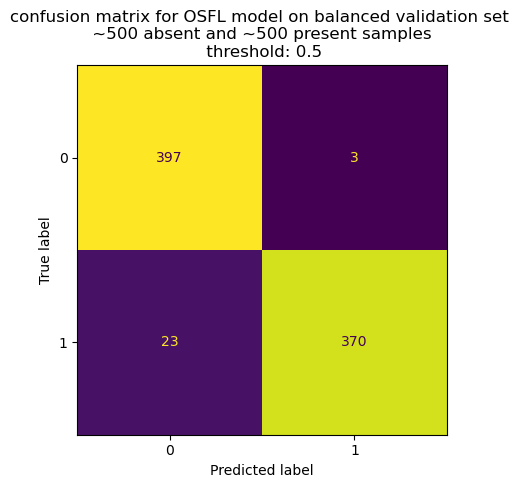

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.interactive_confusion_matrix(threshold=0.5)>

In [32]:
title="confusion matrix for OSFL model on balanced validation set \n ~500 absent and ~500 present samples"


cm = plot_confusion_matrix(balanced_valid_df,predictions,threshold=0.5, title=title)
def interactive_confusion_matrix(threshold=0.5):
    cm = plot_confusion_matrix(balanced_valid_df,predictions,threshold=threshold, title=title)
interact(interactive_confusion_matrix, threshold=(0,1,0.01))

# Plot OSFL model metrics across thresholds for the balanced validation set

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


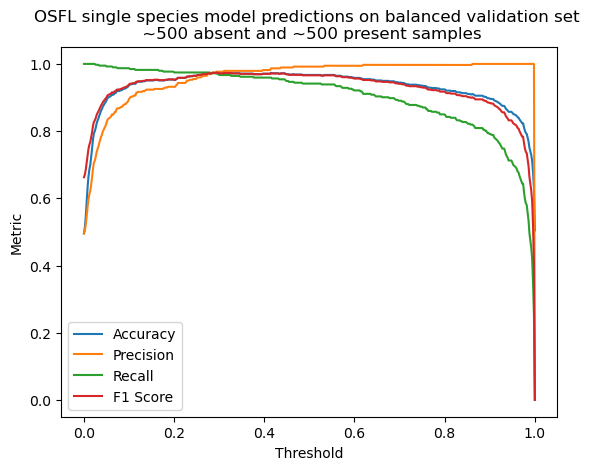

In [33]:
title = "OSFL single species model predictions on balanced validation set \n ~500 absent and ~500 present samples"
plot_data, legend = plot_metrics_across_thresholds(balanced_valid_df, 'predicted', 'target_present', title=title)

# Make hawkears predictions on each clip in the balanced validation set:
1. Enumerate the clips in the dataset for easier file naming
2. Make the save paths to save the audio to
3. Save the clips to disk
4. Run hawkears on the clips and output to the folder specified by __predictions path__ 
5. Load the predictions ready for processing the metrics

In [34]:
# Add an index to the validation clips to use as a file ID
balanced_valid_df["file_ID"] = 0
balanced_valid_df.loc[:, 'file_ID'] = range(0, len(balanced_valid_df))
balanced_valid_df.loc[:, 'file_ID'] = balanced_valid_df['file_ID'].astype(int)
balanced_valid_df.head()

recording_url  \
file                                               start_time end_time                                                      
../../data/raw/recordings/OSFL/recording-4918.flac 7.5        10.5      https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
../../data/raw/recordings/OSFL/recording-291522... 0.0        3.0       https://wildtrax-aru-ca.s3.ca-central-1.amazon...   
../../data/raw/recordings/OSFL/recording-291531... 28.5       31.5      https://wildtrax-aru-ca.s3.ca-central-1.amazon...   
../../data/raw/recordings/OSFL/recording-291875... 7.5        10.5      https://wildtrax-aru-ca.s3.ca-central-1.amazon...   
../../data/raw/recordings/OSFL/recording-291902... 15.0       18.0      https://wildtrax-aru-ca.s3.ca-central-1.amazon...   

                                                                       task_method  \
file                                               start_time end_time               
../../data/raw/recordings/OSFL/recording-4918.flac 7.5        10.5            1SPM   
../../data/raw/recordings/OSFL/recording-291522... 0.0        3.0             1SPT   
../../data/raw/recordings/OSFL/recording-291531... 28.5       31.5            1SPT   
../../data/raw/recordings/OSFL/recording-291875... 7.5        10.5            1SPT   
../../data/raw/recordings/OSFL/recording-291902... 15.0       18.0            1SPT   

                                                                                                             project  \
file                                               start_time end_time                                                 
../../data/raw/recordings/OSFL/recording-4918.flac 7.5        10.5               Boreal Wetland Community Monitoring   
../../data/raw/recordings/OSFL/recording-291522... 0.0        3.0       CWS-Ontario Birds of James Bay Lowlands 2021   
../../data/raw/recordings/OSFL/recording-291531... 28.5       31.5      CWS-Ontario Birds of James Bay Lowlands 2021   
../../data/raw/recordings/OSFL/recording-291875... 7.5        10.5      CWS-Ontario Birds of James Bay Lowlands 2021   
../../data/raw/recordings/OSFL/recording-291902... 15.0       18.0      CWS-Ontario Birds of James Bay Lowlands 2021   

                                                                               detection_time  \
file                                               start_time end_time                          
../../data/raw/recordings/OSFL/recording-4918.flac 7.5        10.5      [9.49, 67.31, 125.88]   
../../data/raw/recordings/OSFL/recording-291522... 0.0        3.0                 [0.03, 1.4]   
../../data/raw/recordings/OSFL/recording-291531... 28.5       31.5      [11.65, 29.73, 40.33]   
../../data/raw/recordings/OSFL/recording-291875... 7.5        10.5                [0.7, 8.91]   
../../data/raw/recordings/OSFL/recording-291902... 15.0       18.0                    [16.49]   

                                                                              tag_duration  \
file                                               start_time end_time                       
../../data/raw/recordings/OSFL/recording-4918.flac 7.5        10.5      [0.86, 1.05, 0.85]   
../../data/raw/recordings/OSFL/recording-291522... 0.0        3.0             [0.45, 1.48]   
../../data/raw/recordings/OSFL/recording-291531... 28.5       31.5      [1.01, 1.51, 0.93]   
../../data/raw/recordings/OSFL/recording-291875... 7.5        10.5            [1.05, 1.54]   
../../data/raw/recordings/OSFL/recording-291902... 15.0       18.0                  [1.34]   

                                                                         latitude  \
file                                               start_time end_time              
../../data/raw/recordings/OSFL/recording-4918.flac 7.5        10.5      57.416944   
../../data/raw/recordings/OSFL/recording-291522... 0.0        3.0       51.146700   
../../data/raw/recordings/OSFL/recording-291531... 28.5       31.5      51.520900   
../../data/raw/recording

In [35]:
# Make a path to save the balanced validation set clips to
save_path = data_path / "processed" / "balanced_validation_set" / "clips"
Path.mkdir(save_path, exist_ok=True, parents=True)

# Save the metadata in the same place or load it if there is already a saved version
if Path.exists(save_path.parent / "balanced_validation_set.pkl"):
    balanced_valid_df = pd.read_pickle(save_path.parent / "balanced_validation_set.pkl")
    print("loading existing metadata")
else: 
    save_dataframe_clips_to_disk(balanced_valid_df, save_path)
    balanced_valid_df.to_pickle(save_path.parent / "balanced_validation_set.pkl")
    print("saving metadata")

loading existing metadata


In [36]:
save_dataframe_clips_to_disk(balanced_valid_df, save_path)

Directory is not empty. Set an empty save directory before saving clips.


In [37]:
predictions_path = save_path.parent / "hawkears"
hawkears_files = glob.glob(str(predictions_path / '*.txt'))
hawkears_df = hawkears_files_to_df(hawkears_files)

In [38]:
hawkears_df.rename(columns={"confidence": "target_present"}, inplace=True)

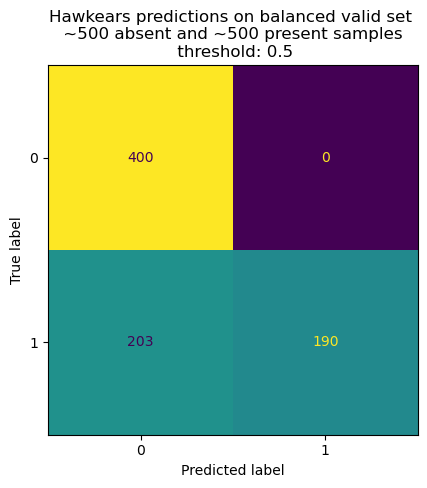

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.interactive_confusion_matrix(threshold=0.5)>

In [39]:
title = "Hawkears predictions on balanced valid set \n ~500 absent and ~500 present samples"
cm = plot_confusion_matrix(balanced_valid_df,hawkears_df,threshold=0.5, title=title)
def interactive_confusion_matrix(threshold=0.5):
    cm = plot_confusion_matrix(balanced_valid_df,hawkears_df,threshold=threshold, title=title)
interact(interactive_confusion_matrix, threshold=(0,1,0.01))


In [40]:
preds, targets, scores = get_binary_targets_scores(balanced_valid_df, hawkears_df, 0.5)
df_scores_labels = pd.DataFrame({'targets': targets, 'hawkears_scores': scores})
df_scores_labels.head()

targets  hawkears_scores
0      1.0             0.90
1      1.0             0.83
2      1.0             0.97
3      1.0             0.95
4      1.0             0.96

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-

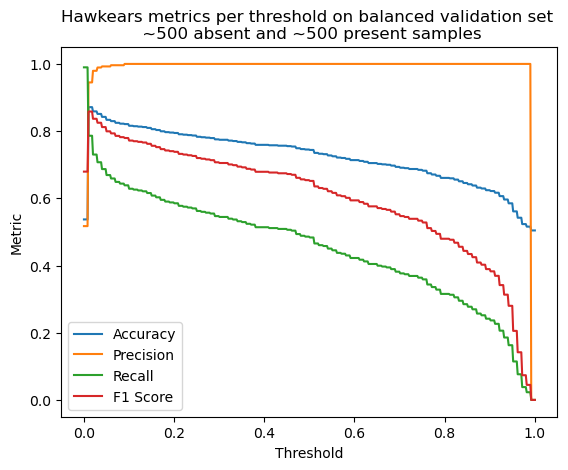

In [41]:
title = "Hawkears metrics per threshold on balanced validation set \n ~500 absent and ~500 present samples"
plot_data, legend = plot_metrics_across_thresholds(df_scores_labels, 'hawkears_scores', 'targets', title=title)


This is our last chance to go back and re-train the model, since the next stage will involve looking at the test set to check performance against samples we deliberately withheld from the model training loop in order to avoid overfitting the model to the specifics of the test set. 